ver 1:
simple CNN

# Lib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import random

# CFG

In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
class CFG:
    batch = 128
    shuffle = True
    num_classes = 10
    learning_rate = 0.0001
    epoch = 20

    H = 28
    W = 28

# Read data

In [4]:
# Load the dataset using NumPy
# Load train data
train_data = np.loadtxt('train.csv', delimiter=',', skiprows=1)
train_labels = train_data[:, 0]  # Labels 0 and 1
train_data = train_data[:, 1:]   # Pixels

## Checking

In [5]:
train_labels

array([1., 0., 1., ..., 7., 6., 9.])

In [6]:
np.unique(train_labels) # from 0 to 9

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [7]:
train_data.shape

(42000, 784)

## Plot 

In [8]:
train_data = np.reshape(train_data, (train_data.shape[0],28,28,1)).copy()/255

In [9]:
train_data.shape

(42000, 28, 28, 1)

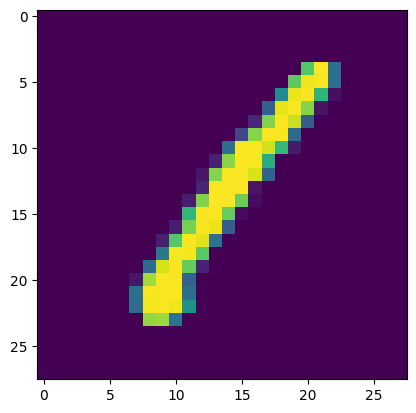

In [10]:
plt.imshow(train_data[0])

In [11]:
train_data = np.einsum('bhwc ->bchw',train_data) 

In [12]:
train_data.shape

(42000, 1, 28, 28)

In [13]:
import numpy as np

class CustomDataLoader:
    def __init__(self, data, targets, batch_size, shuffle=True, drop_last=False):
        self.data = data
        self.targets = targets
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.num_samples = len(self.data)
        self.indices = np.arange(self.num_samples)
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __iter__(self):
        for start_idx in range(0, self.num_samples, self.batch_size):
            end_idx = start_idx + self.batch_size
            if self.drop_last and end_idx > self.num_samples:
                continue

            batch_indices = self.indices[start_idx:end_idx]
            batch_data = self.data[batch_indices]
            batch_targets = self.targets[batch_indices]
            
            yield batch_data, batch_targets
    
    def __len__(self):
        if self.drop_last:
            return self.num_samples // self.batch_size
        else:
            return (self.num_samples + self.batch_size - 1) // self.batch_size


In [14]:
trainloader = CustomDataLoader(train_data[:10000].copy(), train_labels[:10000].copy(), CFG.batch, shuffle=CFG.shuffle, drop_last =True)
testloader = CustomDataLoader(train_data[10001:].copy(), train_labels[10001:].copy(), CFG.batch, shuffle=CFG.shuffle, drop_last =True)

# Linaer

In [15]:
# Define Linear layer class
class Linear:
    def __init__(self, in_features, out_features):
#         self.W = np.random.randn(in_features, out_features) * 0.01  # Initialize weights
        self.W = np.random.randn(in_features, out_features) 
        self.b = np.random.randn(out_features)  # Initialize bias
        self.gradW = np.zeros_like(self.W)  # Gradient of the layer weights
        self.gradB = np.zeros_like(self.b)  # Gradient of the layer bias

    def forward(self, x):
        self.input = x  # Store input for backpropagation
        return np.dot(x, self.W) + self.b

    def backward(self, grad_output):
        self.gradW = np.dot(self.input.T, grad_output)
        self.gradB = np.sum(grad_output, axis=0)
        return np.dot(grad_output, self.W.T)  # Gradient for the previous layer
    def __call__(self, x):
        return self.forward(x)
# Define ReLU activation class
class ReLU:
    def forward(self, x):
        self.input = x  # Store input for backpropagation
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * (self.input > 0)
    
    def __call__(self,x):
        return self.forward(x)

In [16]:
class Softmax:
    def __init__(self):
        self.output = None

    def forward(self, x):
        # Compute the exponential terms in a stable way.
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        
        # Compute the softmax output
        self.output = x_exp / np.sum(x_exp, axis=1, keepdims=True)
        
        return self.output

    def backward(self, d_output):
        # Using broadcasting and vectorization to compute d_input in one shot
        output_expanded = np.expand_dims(self.output, axis=2)  # Expand output dims for broadcasting
        d_output_expanded = np.expand_dims(d_output, axis=2)  # Expand d_output dims for broadcasting

        jacobian_matrix = np.eye(self.output.shape[1]) - output_expanded * np.swapaxes(output_expanded, 1, 2)
        d_input = np.einsum('ijk,ikj->ik', jacobian_matrix, d_output_expanded).squeeze()

        return d_input

    def __call__(self, x):
        return self.forward(x)

class CrossEntropyLoss:
    def __init__(self):
        self.softmax = Softmax()
        self.logits = None
        self.labels = None
        self.epsilon = 1e-18  # Adding epsilon for numerical stability

    def forward(self, logits, labels):
        # Apply Softmax to logits and clip values
        probs = logits.clip(min=self.epsilon,max=None)
        probs = self.softmax.forward(probs)
        # Add a small constant to avoid log(0)
        
        log_probs = np.log(probs)

        # Calculate the loss
        self.logits = logits
        self.labels = labels
        n_samples = logits.shape[0]
        log_likelihood = -np.sum(labels * log_probs)  # Using log_probs
        loss = log_likelihood / n_samples
    
        return loss


    def backward(self):
        n_samples = self.logits.shape[0]
        
        # Direct gradient for cross-entropy loss with softmax is just the difference
        # between the predicted probabilities and the actual one-hot encoded labels
        d_logits = self.softmax.output - self.labels
        d_logits /= n_samples
        
        return d_logits

    def __call__(self, y_pred, y_true):
        return self.forward(y_pred, y_true)

In [17]:
# #working
# class Conv2d:
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.padding = padding
#         self.W = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
#         self.b = np.zeros((out_channels,))

#         self.gradW = np.zeros_like(self.W)
#         self.gradB = np.zeros_like(self.b)
#         self.cache = None

#     def forward(self, x):
#         batch_size, in_channels, in_height, in_width = x.shape
#         out_channels = self.W.shape[0]

#         out_height = (in_height - self.kernel_size + 2 * self.padding) // self.stride + 1
#         out_width = (in_width - self.kernel_size + 2 * self.padding) // self.stride + 1

#         if self.padding > 0:
#             x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), 'constant')

#         self.cache = x

#         # Initialize output tensor
#         output = np.zeros((batch_size, out_channels, out_height, out_width))

#         # Using np.einsum to handle the convolution
#         for i in range(0, in_height - self.kernel_size + 1, self.stride):
#             for j in range(0, in_width - self.kernel_size + 1, self.stride):
#                 x_slice = x[:, :, i:i + self.kernel_size, j:j + self.kernel_size]
#                 output[:, :, i // self.stride, j // self.stride] = np.einsum('ijkl, ojkl -> io', x_slice, self.W) + self.b

#         return np.real(output)

#     def backward(self, grad_output):
#         x = self.cache
#         batch_size, out_channels, _, _ = grad_output.shape

#         grad_input = np.zeros_like(x)
#         self.gradW = np.zeros_like(self.W)
#         self.gradB = np.zeros_like(self.b)

#         for i in range(0, grad_input.shape[2] - self.kernel_size + 1, self.stride):
#             for j in range(0, grad_input.shape[3] - self.kernel_size + 1, self.stride):
#                 x_slice = x[:, :, i:i + self.kernel_size, j:j + self.kernel_size]
#                 grad_output_slice = grad_output[:, :, i // self.stride, j // self.stride]

#                 # Update gradient of input using einsum
#                 grad_input[:, :, i:i + self.kernel_size, j:j + self.kernel_size] += np.einsum('io, ojkl -> ijkl', grad_output_slice, self.W)
                
#                 # Update gradient of weights using einsum
#                 self.gradW += np.einsum('io, ijkl -> ojkl', grad_output_slice, x_slice)

#                 # Update gradient of bias
#                 self.gradB += np.sum(grad_output_slice, axis=0)
#         return np.real(grad_input)

#     def __call__(self, x):
#         return self.forward(x)

In [18]:
import numpy as np
from numpy.fft import fft2, ifft2

In [19]:
# kernel_size = 3
# stride = 1
# padding = 0
# out_channels = 5
# in_channels = 5
# W = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
# b = np.zeros(out_channels)
# cache = None

# x = np.random.randn(64, 1, 28, 28)
# batch_size, in_channels, in_height, in_width = x.shape

# out_channels = W.shape[0]

# out_height = (in_height - kernel_size + 2 * padding) // stride + 1
# out_width = (in_width - kernel_size + 2 * padding) // stride + 1

# if padding > 0:
#     x = np.pad(x, ((0, 0), (0, 0), (padding, padding), (padding, padding)), 'constant')

# output = np.zeros((batch_size, out_channels, out_height, out_width))

# x = fft2(x, axes=(2, 3))
# x = np.real(x)
# for i in range(0, in_height - kernel_size + 1, stride):
#             for j in range(0, in_width - kernel_size + 1, stride):
#                 x_slice = x[:, :, i:i + kernel_size, j:j + kernel_size]
#                 output[:, :, i // stride, j // stride] = np.einsum('ijkl, ojkl -> io', x_slice, W) + b
                

In [20]:
# output.shape

In [21]:
# x_slice.shape

In [22]:
# output.shape

In [23]:
# x_slice.shape

In [24]:
from numpy.fft import fft2, ifft2
import numpy as np

class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        self.W = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.b = np.zeros(out_channels)
        self.gradW = np.zeros_like(self.W)
        self.gradB = np.zeros_like(self.b)
        self.padding = padding
        self.stride = stride

    def forward(self, x):
        N, C, H, W = x.shape
        H_out = (H - self.W.shape[2] + 2*self.padding) // self.stride + 1
        W_out = (W - self.W.shape[3] + 2*self.padding) // self.stride + 1
        out = np.zeros((N, self.W.shape[0], H_out, W_out))
        
        for n in range(N):
            for m in range(self.W.shape[0]):
                fft_x = fft2(x[n], (H_out, W_out), axes=[-2, -1])
                fft_w = fft2(self.W[m], (H_out, W_out), axes=[-2, -1])
                conv_freq = fft_x * fft_w
                conv_spatial = np.real(ifft2(conv_freq, axes=[-2, -1]))
                out[n, m] = conv_spatial.sum(axis=0) + self.b[m]
                
        return out

    def backward(self, dout):
        N, F, H_out, W_out = dout.shape
        C = self.W.shape[1]
        
        self.gradB = np.sum(dout, axis=(0, 2, 3))
        self.gradW = np.zeros_like(self.W)
        dx = np.zeros((N, F, H_out, W_out))
        
        for n in range(N):
            for f in range(F):
                fft_dout = fft2(dout[n, f], axes=[-2, -1])
                
                for c in range(C):
                    fft_w = fft2(self.W[f, c], (H_out, W_out), axes=[-2, -1])  # Match the shape
                    
                    fft_dx = fft_dout * fft_w
                    dx_spatial = np.real(ifft2(fft_dx, axes=[-2, -1]))
                    dx[n, c] += dx_spatial
                    
                    fft_x = fft2(dx_spatial, axes=[-2, -1])  # Use already calculated dx_spatial for calculating dW
                    fft_dW = fft_dout * fft_x
                    dW_spatial = np.real(ifft2(fft_dW, axes=[-2, -1]))
                    
                    self.gradW[f, c] += dW_spatial[:self.W.shape[2], :self.W.shape[3]]
        
        return dx
    def __call__(self, x):
        return self.forward(x)
# Example usage
conv = Conv2d(3, 6, 3, padding=0)
input_data = np.random.randn(10, 3, 32, 32)
output = conv.forward(input_data)
print("Forward pass, output shape:", output.shape)

dout = np.random.randn(*output.shape)

dx = conv.backward(dout)
print("Backward pass, dx shape:", dx.shape)


Forward pass, output shape: (10, 6, 30, 30)
Backward pass, dx shape: (10, 6, 30, 30)


In [25]:
# out_H = (input_data[0] - kernel_size +2*1)//stride + 1

In [26]:
def mean(x):
    return np.sum(x)/x.size
def var(x):
    return mean(np.square(x-mean(x)))
def std(x):
    return np.sqrt(var(x))
def median(x):
    sorted_x = np.sort(x)  # Sort the array in ascending order
    n = x.size  # Get the size of the array
    
    if n % 2 == 1:  # If the size is odd
        return sorted_x[n // 2]  # Return the middle element
    else:  # If the size is even
        m1 = sorted_x[n // 2 - 1]  # Get the first middle element
        m2 = sorted_x[n // 2]  # Get the second middle element
        return (m1 + m2) / 2  # Return the average of the two middle elements

        

In [27]:
arr = [0,1,2,3,4,5,6,7,8,9]
arr = np.array(arr)
print(mean(arr), var(arr), std(arr), median(arr))

4.5 8.25 2.8722813232690143 4.5


In [28]:
import numpy as np

class MaxPool2d:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size  # Define the kernel size for max pooling
        self.cache = {}  # Cache to store intermediate values for backward computation
    
    def forward(self, x):
        # Get the shape of input tensor
        N, C, H, W = x.shape
        
        # Compute the dimensions of the output after max pooling
        H_out = H // self.kernel_size
        W_out = W // self.kernel_size
        
        # Initialize output tensor
        out = np.zeros((N, C, H_out, W_out))
        
        # Store the indices where max values are found
        self.cache['max_indices'] = np.zeros((N, C, H_out, W_out), dtype=int)
        
        # Perform max pooling
        for i in range(H_out):
            for j in range(W_out):
                # Extract each patch
                patch = x[:, :, i*self.kernel_size:(i+1)*self.kernel_size, j*self.kernel_size:(j+1)*self.kernel_size]
                
                # Find the maximum value in each patch and its index
                out[:, :, i, j] = np.max(patch, axis=(2, 3))
                self.cache['max_indices'][:, :, i, j] = np.argmax(patch.reshape(N, C, -1), axis=2)
        
        return out
    
    def backward(self, d_out):
        # Retrieve cached values
        max_indices = self.cache['max_indices']
        
        # Get the shape of the output gradient tensor
        N, C, H_out, W_out = d_out.shape
        
        # Initialize the input gradient tensor
        d_x = np.zeros((N, C, H_out * self.kernel_size, W_out * self.kernel_size))
        
        # Perform backward pass to propagate the gradients
        for i in range(H_out):
            for j in range(W_out):
                # Initialize a zero patch for each input patch
                d_patch = np.zeros((N, C, self.kernel_size, self.kernel_size))
                
                # Get the indices where max values are found in the forward pass
                indices = max_indices[:, :, i, j]
                
                # Update the patch with corresponding gradients
                d_patch.reshape(N, C, -1)[np.arange(N)[:, None], np.arange(C), indices] = d_out[:, :, i, j]
                
                # Place the computed gradient patch back into the gradient tensor
                d_x[:, :, i*self.kernel_size:(i+1)*self.kernel_size, j*self.kernel_size:(j+1)*self.kernel_size] = d_patch
        
        return d_x
    def __call__(self, x):
        return self.forward(x)
# Test the MaxPool2d class
x = np.random.randn(2, 3, 4, 4)  # Random tensor with shape (batch_size, channels, height, width)
max_pool = MaxPool2d(2)
out = max_pool.forward(x)
d_out = np.random.randn(*out.shape)
d_x = max_pool.backward(d_out)

print("Input:", x.shape)
print("Output:", out.shape)
print("Output gradient:", d_out.shape)
print("Input gradient:", d_x.shape)


Input: (2, 3, 4, 4)
Output: (2, 3, 2, 2)
Output gradient: (2, 3, 2, 2)
Input gradient: (2, 3, 4, 4)


In [29]:
# import numpy as np

# import numpy as np

# class MaxPool2d:
#     def __init__(self, kernel_size):
#         self.kernel_size = kernel_size
#         self.cache = None  # To store forward-pass data needed for backpropagation

#     def forward(self, x):
#         N, C, H, W = x.shape
#         H_out = H // self.kernel_size
#         W_out = W // self.kernel_size

#         # Reshape for max pooling
#         x_reshaped = x.reshape(N, C, H_out, self.kernel_size, W_out, self.kernel_size)

#         # Perform max pooling
#         out = x_reshaped.max(axis=(3, 5))

#         # Store indices of max values
#         self.cache = np.zeros((N, C, H_out, W_out), dtype=int)
#         for i in range(self.kernel_size):
#             for j in range(self.kernel_size):
#                 mask = (x_reshaped[:,:, :, i, :, j] == out)
#                 self.cache = np.logical_or(self.cache, mask)

#         return out

# #     def backward(self, grad_output):
# #         N, C, H_out, W_out = grad_output.shape

# #         # Initialize grad_input to zeros
# #         grad_input = np.zeros((N, C, H_out * self.kernel_size, W_out * self.kernel_size), dtype=grad_output.dtype)

# #         # Scatter gradient to the positions of max values
# #         for i in range(self.kernel_size):
# #             for j in range(self.kernel_size):
# #                 grad_input[:,:, i::self.kernel_size, j::self.kernel_size] += self.cache * grad_output

# #         return grad_input
#     def backward(self, grad_output):
#         print(f"Shape of grad_output at beginning of maxpool backward: {grad_output.shape}")
#         N, C, H_out, W_out = grad_output.shape
        
#         # Initialize grad_input
#         grad_input = np.zeros((N, C, H_out * self.kernel_size, W_out * self.kernel_size), dtype=grad_output.dtype)
#         print('grand_input shape',grad_input.shape)
# #         for i in range(self.kernel_size):
# #             for j in range(self.kernel_size):
                
# #                 print(f"Shape of mask: {mask.shape}")
# #                 mask_broad = np.broadcast_to(mask, grad_input[:, :, i::self.kernel_size, j::self.kernel_size].shape)
# #                 grad_output_broad = np.broadcast_to(grad_output[:, :, i//self.kernel_size, j//self.kernel_size], grad_input[:, :, i::self.kernel_size, j::self.kernel_size].shape)

# #                 grad_input[:, :, i::self.kernel_size, j::self.kernel_size] += mask_broad * grad_output_broad
# #         for n in range(N):
#         # Warning: This is computationally inefficient
#         for n in range(N):
#             for c in range(C):
#                 for h in range(0, H_out, self.kernel_size):
#                     for w in range(0, W_out, self.kernel_size):
#                         mask = self.cache[:, :, i::self.kernel_size, j::self.kernel_size]
#                         grad_input[n, c, h:h+self.kernel_size, w:w+self.kernel_size] += mask[n, c, h//self.kernel_size, w//self.kernel_size] * grad_output[n, c, h//self.kernel_size, w//self.kernel_size]
        
#         print(f"Shape of grad_input at end of maxpool backward: {grad_input.shape}")
#         return grad_input

#     def __call__(self, x):
#         return self.forward(x)

In [30]:
X,y = next(iter(trainloader))

In [31]:
maxpool = MaxPool2d(kernel_size = 2)

In [32]:
maxpool1 = MaxPool2d(kernel_size = 1)

In [33]:
conv = Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0, stride=1)

conv(X).shape

(128, 16, 26, 26)

In [34]:
maxpool1(conv(conv(maxpool(conv(conv(X)))))).shape

(128, 16, 8, 8)

In [35]:
maxpool(conv(X)).shape

(128, 16, 13, 13)

In [36]:
kernel_size = 3
padding = 0
stride= 1
out_H = (CFG.H - kernel_size +2*padding) //stride+1
out_H

26

In [37]:
kernel_size = 2
out_H = out_H // kernel_size

In [38]:
out_H

13

In [39]:
kernel_size=3
out_H = (out_H- kernel_size +2*padding) //stride+1
out_H

11

In [40]:
#MaxPool2d shape
kernel_size = 2
out_H = 5 // kernel_size

In [41]:
out_H

2

In [42]:
class SimpleCNN:
    def __init__(self, out_dim):
        # 64,1,26,26
        self.conv1 = Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0, stride=1)
        # 64,1,24,24
#         self.conv2 = Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=1)
        # 64,1,12,12
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size = 2)
        
        # 64,1,10,10
#         self.conv3 = Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0, stride=1)
#         # 64,1,5,5
#         self.conv4 = Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0, stride=1)
#         # 64,1,2,2
#         self.maxpool2 = MaxPool2d(kernel_size = 1)
        
        self.fc1 = Linear(in_features = 16 * 13*13, out_features = 64)
        self.relu2 = ReLU()
        self.fc2 = Linear(in_features=64, out_features=64)
        self.relu3 = ReLU()
        self.fc3 = Linear(in_features=64, out_features=out_dim)
        self.relu4 = ReLU()
        self.soft = Softmax()

    def forward(self, x):
        x = self.conv1(x)
#         print(x)
#         print(x.shape)
#         x = self.conv2(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
#         x = self.conv3(x)
#         x = self.conv4(x)  
#         x = self.maxpool2(x)
#         print(x.shape)
        x = x.reshape(-1, 16 * 13*13)
#         print(x.shape)
        x = self.relu2(self.fc1(x))
        x = self.relu3(self.fc2(x))
        x = self.relu4(self.fc3(x))
#         print(x.shape)
        x = self.soft(x)
        return x
    
    def backward(self, grad_output):
        grad_output = self.soft.backward(grad_output)
        grad_output = self.relu4.backward(grad_output)
        grad_output = self.fc3.backward(grad_output)
        grad_output = self.relu3.backward(grad_output)
        grad_output = self.fc2.backward(grad_output)
        grad_output = self.relu2.backward(grad_output)
        grad_output = self.fc1.backward(grad_output)
        grad_output = grad_output.reshape(-1, 16,  13,13)
#         print(grad_output.shape)
#         grad_output = self.maxpool2.backward(grad_output)
#         print(grad_output.shape)
#         grad_output = self.conv4.backward(grad_output)
#         grad_output = self.conv3.backward(grad_output)
        grad_output = self.maxpool1.backward(grad_output)
        grad_output = self.relu1.backward(grad_output)
#         grad_output = self.conv2.backward(grad_output)
        grad_output = self.conv1.backward(grad_output)
        
    def params(self):
        # Collect parameters and their gradients in a list of tuples
        parameters = [
            (self.conv1.W, self.conv1.gradW),
            (self.conv1.b, self.conv1.gradB),
#             (self.conv2.W, self.conv2.gradW),
#             (self.conv3.W, self.conv3.gradW),
#             (self.conv4.W, self.conv4.gradW),
            (self.fc1.W, self.fc1.gradW),
            (self.fc1.b, self.fc1.gradB),
            (self.fc2.W, self.fc2.gradW),
            (self.fc2.b, self.fc2.gradB),
            (self.fc3.W, self.fc3.gradW),
            (self.fc3.b, self.fc3.gradB)
        ]
        return parameters
    def __call__(self, x):
        return self.forward(x)

In [43]:
model = SimpleCNN(10)

In [44]:
class SGD:    
    @classmethod
    def step(cls, parameters, lr):
        for param, grad in parameters:
            param -= lr * grad  # Update using gradient and learning rate
            
    @classmethod
    def zero_grad(cls, parameters):
        for param, grad in parameters:
            grad.fill(0)


In [45]:
loss_fn = CrossEntropyLoss()

In [46]:
optimizer = SGD()

In [47]:
def train(dataloader, model, loss_fn, optimizer):
    size = dataloader.num_samples
    num_batches =(len(dataloader) + CFG.batch - 1) // CFG.batch
    
    train_loss, correct = 0, 0
    
    for b, (X, y) in enumerate(dataloader):
        y = y.astype(int)
        # Convert target labels to one-hot encoding
        y_one_hot = np.eye(CFG.num_classes)[y]
        pred = model(X)
        loss = loss_fn(pred, y_one_hot)
        grad = loss_fn.backward()
        
        model.backward(grad)
        # Update weights
        optimizer.step(model.params(), CFG.learning_rate)  # To update parameters
        optimizer.zero_grad(model.params())  # To reset gradients to zero
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).sum()       
    train_loss /= num_batches
    accuracy = (100 * correct) / size
    print(f"Train error:\n Accuracy: {accuracy:.1f}%  Avg loss: {train_loss:.8f}")

In [48]:
def test(dataloader, model, loss_fn):
    test_loss, correct, total = 0, 0, 0
    
    for b, (X, y) in enumerate(testloader):
        y = y.astype(int)
        y = np.eye(CFG.num_classes)[y]
        pred = model(X)
        test_loss += loss_fn(pred, y)
        total += len(y)
        correct += (pred.argmax(1) == y.argmax(1)).sum()
    loss = test_loss / b
    correct = 100.*correct/total
    print(f"Test Error:\n Accuracy: {(correct):>.1f}%, Avg loss: {(loss):>.8f}\n")

In [49]:
for t in range(CFG.epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader,model, loss_fn, optimizer)

    test(testloader, model, loss_fn)


Epoch 1
-------------------------------
Train error:
 Accuracy: 11.2%  Avg loss: 183.25807262
Test Error:
 Accuracy: 12.8%, Avg loss: 2.34217186

Epoch 2
-------------------------------
Train error:
 Accuracy: 14.5%  Avg loss: 180.64410242
Test Error:
 Accuracy: 15.2%, Avg loss: 2.31865685

Epoch 3
-------------------------------
Train error:
 Accuracy: 16.9%  Avg loss: 178.76799157
Test Error:
 Accuracy: 18.2%, Avg loss: 2.28776806

Epoch 4
-------------------------------
Train error:
 Accuracy: 20.3%  Avg loss: 176.08172183
Test Error:
 Accuracy: 21.3%, Avg loss: 2.25751534

Epoch 5
-------------------------------
Train error:
 Accuracy: 23.2%  Avg loss: 173.80987893
Test Error:
 Accuracy: 23.8%, Avg loss: 2.23211205

Epoch 6
-------------------------------
Train error:
 Accuracy: 25.6%  Avg loss: 171.99751100
Test Error:
 Accuracy: 26.0%, Avg loss: 2.20956715

Epoch 7
-------------------------------
Train error:
 Accuracy: 27.7%  Avg loss: 170.33000627
Test Error:
 Accuracy: 28.5%, 

In [50]:
size = trainloader.num_samples
num_batches =(len(trainloader) + CFG.batch - 1) // CFG.batch

train_loss, correct = 0, 0

for b, (X, y) in enumerate(trainloader):
    y = y.astype(int)
    # Convert target labels to one-hot encoding
    y_one_hot = np.eye(CFG.num_classes)[y]
    pred = model(X)
    pred = pred.astype(np.int64)
    loss = loss_fn(pred, y_one_hot)
    grad = loss_fn.backward()
    
    model.backward(grad)
    # Update weights
    optimizer.step(model.params(), CFG.learning_rate)  # To update parameters
    optimizer.zero_grad(model.params())  # To reset gradients to zero
    train_loss += loss.item()
    correct += (pred.argmax(1) == y).sum()       
train_loss /= num_batches
accuracy = (100 * correct) / size
print(f"Train error:\n Accuracy: {accuracy:.1f}%  Avg loss: {train_loss:.8f}")

Train error:
 Accuracy: 40.8%  Avg loss: 159.81231409


In [51]:
trainloader.num_samples

10000

In [52]:
y

array([9, 4, 2, 0, 6, 9, 3, 5, 5, 2, 0, 7, 7, 5, 7, 5, 3, 4, 1, 4, 3, 1,
       0, 7, 7, 3, 6, 4, 1, 0, 0, 9, 2, 2, 7, 2, 0, 5, 9, 0, 3, 5, 1, 8,
       0, 2, 3, 9, 5, 3, 9, 1, 0, 3, 9, 5, 5, 2, 6, 7, 6, 1, 7, 2, 2, 8,
       6, 6, 8, 6, 0, 4, 3, 3, 8, 8, 5, 8, 2, 4, 9, 7, 8, 1, 3, 8, 6, 8,
       4, 0, 9, 0, 0, 3, 8, 5, 9, 2, 9, 9, 0, 4, 2, 5, 9, 4, 6, 6, 1, 1,
       8, 1, 8, 8, 9, 6, 0, 5, 4, 1, 7, 4, 7, 1, 5, 3, 9, 7])

In [53]:
pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [54]:
test_loss, correct, total = 0, 0, 0
    
for b, (X, y) in enumerate(testloader):
    y = y.astype(int)
    y = np.eye(CFG.num_classes)[y]
    pred = model(X)
    test_loss += loss_fn(pred, y)
    total += len(y)
    correct += (pred.argmax(1) == y.argmax(1)).sum()
loss = test_loss / b
correct = 100.*correct/total
print(f"Test Error:\n Accuracy: {(correct):>.1f}%, Avg loss: {(loss):>.8f}\n")

Test Error:
 Accuracy: 40.6%, Avg loss: 2.06234686

